# Portugal Real Estate Market - Exploratory Data Analysis (EDA)

In this notebook, I analyze the 21,066 property listings scraped from Imovirtual. The goal is to uncover market trends, correlations, and eventually prepare the data for future machine learning models.

In [9]:
import os
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from dotenv import load_dotenv

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Load environment variables from project root
load_dotenv("../.env")

True

## Data Connection & Loading

In [10]:
def get_db_connection():
    return psycopg2.connect(
        host=os.getenv('DB_HOST', 'localhost'),
        database=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD')
    )

try:
    conn = get_db_connection()
    query = "SELECT title, price, distrito, concelho, freguesia, area_m2, room_count, url, scraped_at FROM properties"
    df = pd.read_sql(query, conn)
    conn.close()
    print(f"Success! Loaded {len(df)} records.")
except Exception as e:
    print(f"Error: {e}")

df.head()

Success! Loaded 21066 records.


C:\temp\ipykernel_66960\2058466099.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,title,price,distrito,concelho,freguesia,area_m2,room_count,url,scraped_at
0,Apartamento T3 Novo - Aguada de Cima,250000,Aveiro,Agueda,Aguada De Cima,178.0,3.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:35.018004+00:00
1,Apartamento T3 Novo - Aguada de Cima,250000,Aveiro,Agueda,Aguada De Cima,178.0,3.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:35.018004+00:00
2,Apartamento T3 para venda,328000,Aveiro,Agueda,Agueda E Borralha,109.0,3.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:42.299947+00:00
3,Apartamento T2 para venda,240000,Aveiro,Agueda,Agueda E Borralha,132.0,2.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:42.299947+00:00
4,Apartamento T2 para venda,276000,Aveiro,Agueda,Agueda E Borralha,112.0,2.0,https://www.imovirtual.com/pt/anuncio/apartame...,2026-01-31 01:22:42.299947+00:00


## 2. Basic Data Cleaning & Feature Engineering

Calculate the Price per m² and handle any obvious data inconsistencies.

In [19]:
# Calculate Price per m2 where possible
df['price_per_m2'] = df['price'] / df['area_m2']

# Handle inf or NaN in price_per_m2
df['price_per_m2'] = df['price_per_m2'].replace([np.inf, -np.inf], np.nan)

# Summary statistics
df.describe()

,price,area_m2,room_count,price_per_m2
count,2.106600e+04,2.089800e+04,18061.000000,2.089800e+04
mean,4.310073e+05,3.058371e+02,2.356514,4.267554e+03
std,1.577195e+06,8.974229e+03,1.025408,3.643759e+04
min,0.000000e+00,1.000000e+00,0.000000,0.000000e+00
25%,2.500000e+05,7.807750e+01,2.000000,2.475248e+03
50%,3.250000e+05,1.023900e+02,2.000000,3.378378e+03
75%,4.550000e+05,1.340000e+02,3.000000,4.652450e+03
max,2.200000e+08,1.120000e+06,30.000000,3.728814e+06


## 3. Outlier Detection (IQR)

In [8]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_clean = remove_outliers(df, 'price')
print(f"Removed {len(df) - len(df_clean)} outliers based on price.")

Removed 1742 outliers based on price.


## 4. Market Distribution

### Top 10 Concelhos by Volume

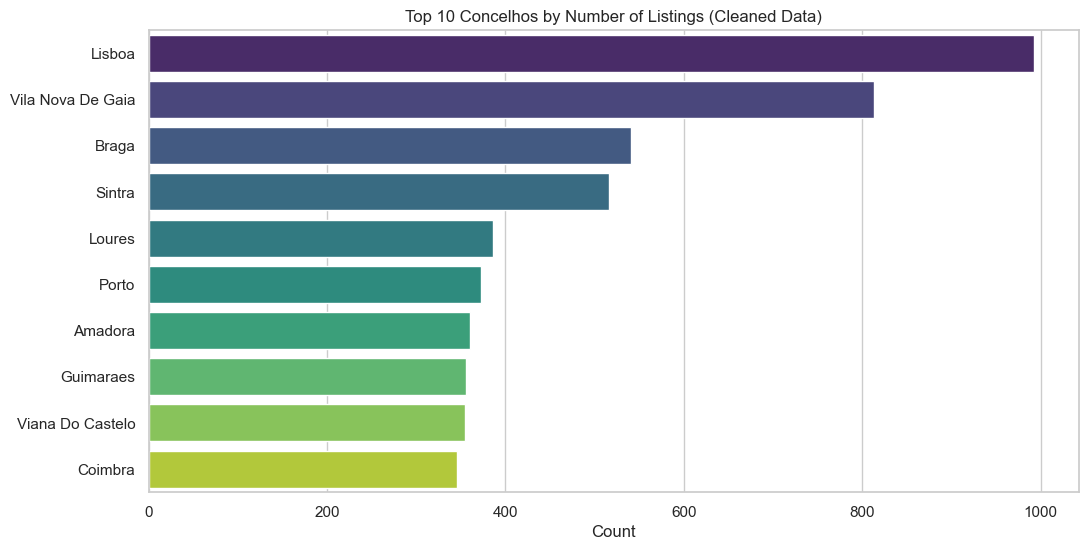

In [12]:
top_concelhos = df_clean['concelho'].value_counts().head(10)
sns.barplot(x=top_concelhos.values, y=top_concelhos.index, palette='viridis')
plt.title('Top 10 Concelhos by Number of Listings (Cleaned Data)')
plt.xlabel('Count')
plt.show()

### Price Distribution

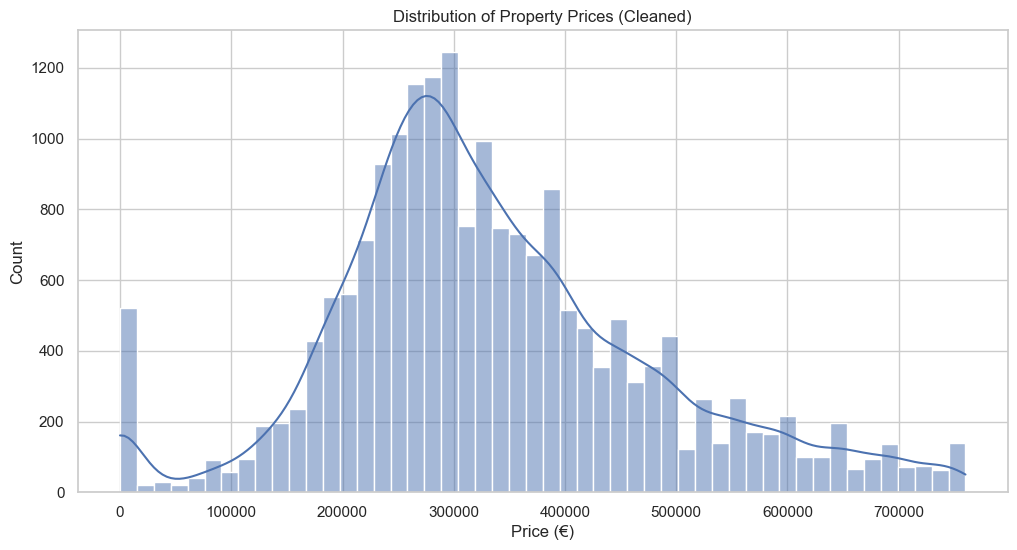

In [13]:
sns.histplot(df_clean['price'], bins=50, kde=True)
plt.title('Distribution of Property Prices (Cleaned)')
plt.xlabel('Price (€)')
plt.show()

## 5. Correlations


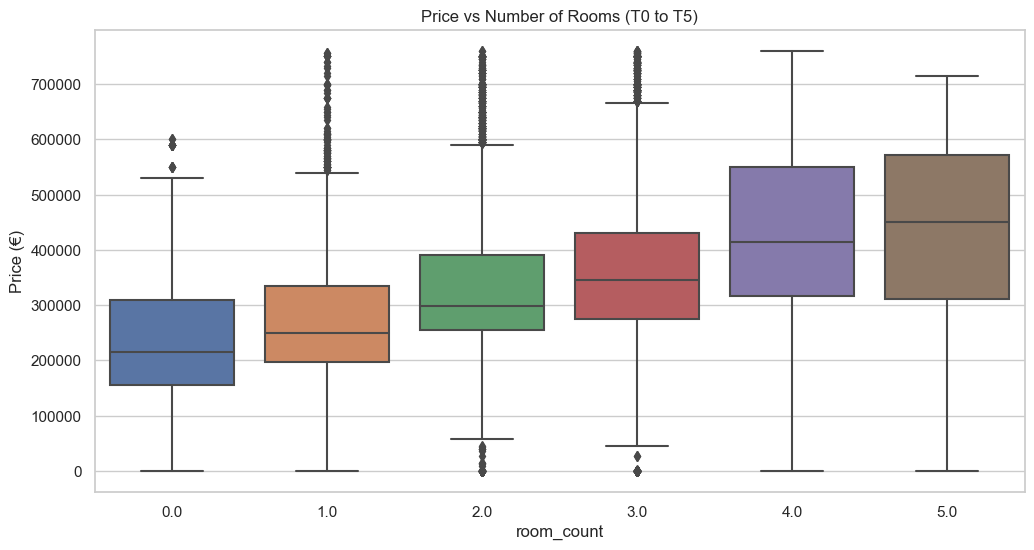

In [20]:
sns.boxplot(x='room_count', y='price', data=df_clean[df_clean['room_count'] <= 5])
plt.title('Price vs Number of Rooms (T0 to T5)')
plt.ylabel('Price (€)')
plt.show()

### Quick comparison example

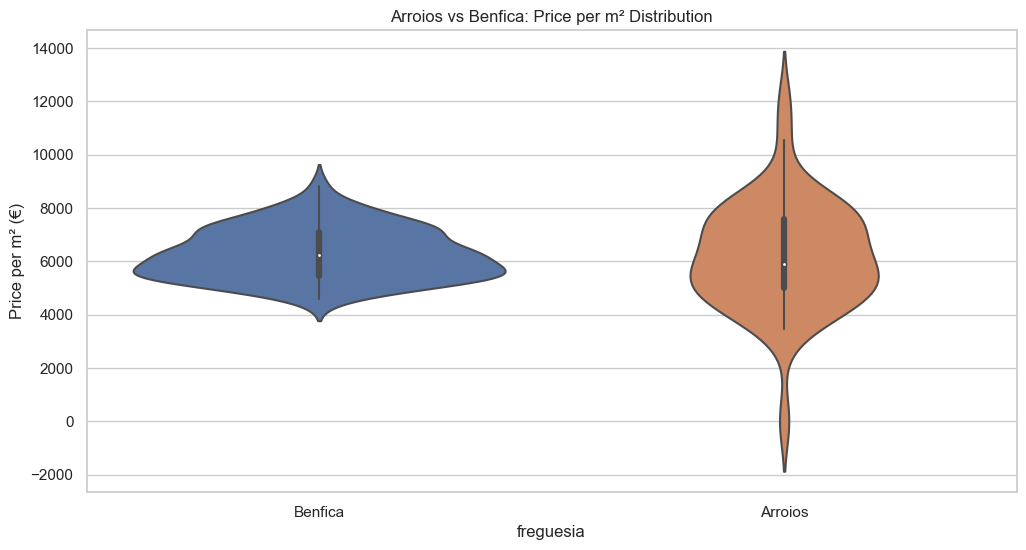

In [21]:
story_df = df_clean[df_clean['freguesia'].isin(['Arroios', 'Benfica'])]
sns.violinplot(x='freguesia', y='price_per_m2', data=story_df)
plt.title('Arroios vs Benfica: Price per m² Distribution')
plt.ylabel('Price per m² (€)')
plt.show()

## 6. Premium Areas: Price per m² by Freguesia

Top 20 most expensive Freguesias (with at least 10 listings).

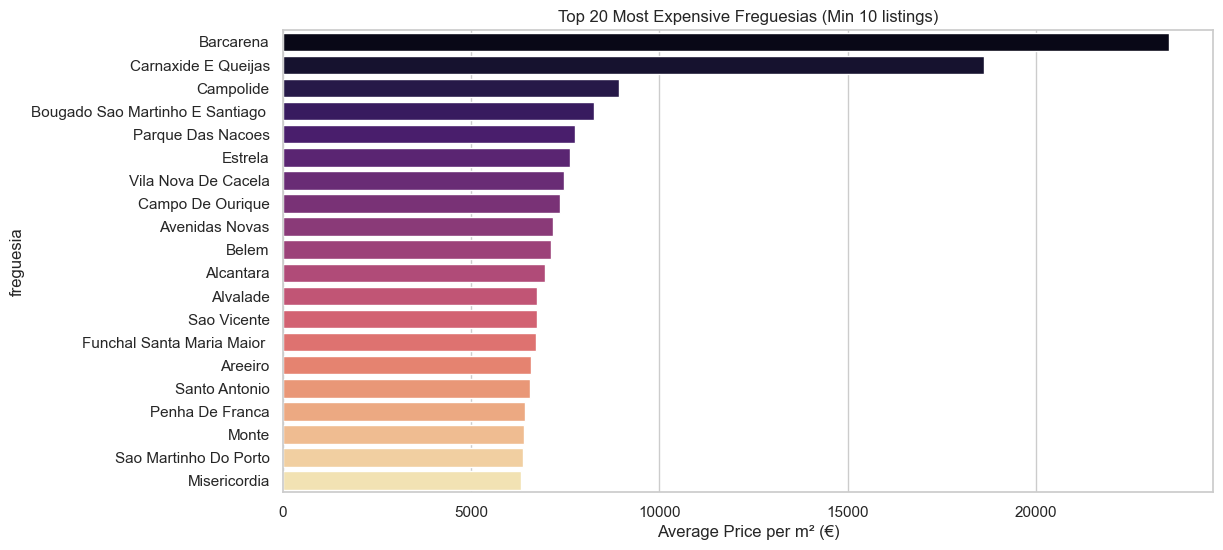

In [22]:
min_listings = 10
freg_stats = df_clean.groupby('freguesia').agg({'price_per_m2': 'mean', 'url': 'count'})
freg_stats = freg_stats[freg_stats['url'] >= min_listings].sort_values('price_per_m2', ascending=False).head(20)

sns.barplot(x=freg_stats['price_per_m2'], y=freg_stats.index, palette='magma')
plt.title('Top 20 Most Expensive Freguesias (Min 10 listings)')
plt.xlabel('Average Price per m² (€)')
plt.show()